# Generating large biochemical models and large drug biochemical models

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Analysis

### Setup

In [5]:
import os 

### parameters 
notebook_name = 'generate_large_model'
sub_id = '1'

## Generation of ground truth model 
model_name = 'v3_small_model_52'
o_random_seed = 6 
parameter_random_seed = 6
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 
simulation_time = 500 
simulation_step = 100

## Feature data generation 
feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 
'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 
data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + sub_id
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/generate_large_model_1/


### Standard Model

In [7]:
### Generate the ground truth model
model_name = 'example_model_1'
seed = 42 
num_species = 100
num_feedback = 25

model_spec = ModelSpecification()
model_spec.generate_specifications(seed, num_species, num_feedback, verbose=0)
# G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)
# runner = roadrunner.RoadRunner(G0.get_sbml_model())

In [8]:
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)

In [9]:
print(G0)

Model Name example_model_1
Number of Reactions 402
Number of State Variables 402
Number of Parameters 1029
Number of Custom Variables 0
Number of Enforced State Values 0
Number of Custom Strings 0



In [10]:
import tellurium as te 

r = te.loada(G0.get_antimony_model())

In [11]:
res = r.simulate(0, 500, 100)

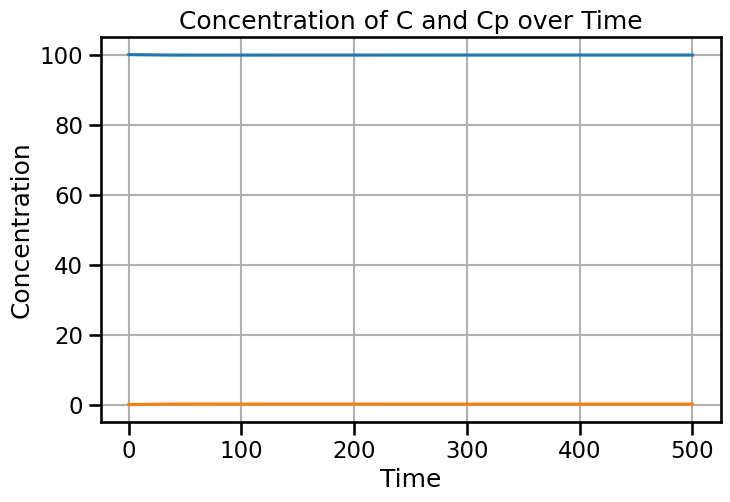

In [12]:
# === PLOT: Visible States Over Time ===

import seaborn as sns
sns.set_context('talk')
sns.axes_style('whitegrid')

# Define key observable states
visible_states = ['C', 'Cp']

# Plot the concentration of visible states over time
plt.figure(figsize=(8, 5))
for state in visible_states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of C and Cp over Time")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'timecourse_example.png')
plt.show()
plt.close()

In [11]:
## Helper functions
import warnings

def sensitivity_analysis(builder: ModelBuilder, specie_name, specie_range, simulation_time, simulation_step):
    all_results = []
    for specie in specie_range:
        builder.set_state(specie_name, specie)
        runner = roadrunner.RoadRunner(builder.get_sbml_model())
        try: 
            res = runner.simulate(0, simulation_time, simulation_step)
            all_results.append(res)
        except Exception as e:
            warnings.warn(f"Simulation failed for specie {specie}: {e}")
            continue
    return all_results

def extract_states_from_results(results, state_name, time_point):
    all_states = []
    for result in results:
        state = result[f'[{state_name}]']
        all_states.append(state[time_point])
    return all_states

def get_sensitivity_scores(states):
    state_sensitivity = []  
    for i, specific_states in enumerate(states):
        # get the max and min of the Cp final state list 
        max_state = max(specific_states)
        min_state = min(specific_states)
        # get the range of the Cp final state list 
        range_state = max_state - min_state
        # append to the list 
        state_sensitivity.append(range_state)
    # print the mean of the state sensitivity
    return state_sensitivity

def summarise_sensitivity_score(state_sensitivity):
    return sum(state_sensitivity) / len(state_sensitivity)

In [12]:
# all_states = []
# for i in range(2500):
#     all_states.append('A'+str(i))
# for i in range(2500):
#     all_states.append('B'+str(i))

# species_perturbation_range = np.arange(1, 5000, 500)
# all_init_species_results = []
# for init_species in all_states: 
#     all_results = sensitivity_analysis(G0, init_species, species_perturbation_range, simulation_time, simulation_step)
#     all_init_species_results.append(all_results)

### Drug Model 

In [13]:
print('Performing sensitivity analysis...')

Performing sensitivity analysis...
